# Conversion Rate Challenge


<img src="image.jpg" width=600 height=300 align=left>



# Description

We have collected data about users of a _anonymous_ company's website. Your project is :

1. Create a model to predict the conversion rate (will the user convert or not?).

2. Find recommendations for the Product & Marketing team to make so that they can improve the conversion rate.

Optimizing conversion rates is one of the most important tasks of a data scientist.

## Table of Contents

I.   [Exploratory data analysis](#1)<br/>

II.  [Data visualization](#2)<br/>

III. [Logistic Regression](#3)<br/>

   1.  [Dataset with all](#1a) <br/>
   2.  [Dataset without outlier and normalize](#1b)<br/>
   3.  [Confusion matrix](#1c)<br/>
   4.  [Classification report](#1d)<br/>
   5.  [Precision - Recall Curve](#1d)<br/>

IV.  [Random over-sampling the minority class with Logistic Regression](#4) <br/>

V.   [Random under-sampling the majority class with Logistic Regression](#5) <br/>

VI.  [Apply Tree-Based Algorithms](#6)<br/>

   1.  [Random Forest classifier](#2a) <br/>
   2.  [Comparaison method between gini and entropy](#2b)<br/>
   3.  [GridsearchCV](#2c)<br/>
   4.  [Under-sampling the majority class with random forest](#2d)<br/>
   
VII.  [SMOTETomek](#7) <br/>

In [1]:
# standard
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

from collections import Counter
# displays all columns and rows
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


In [2]:
# importing data
CRC = pd.read_csv("conversion_data.csv")
CRC1 = pd.read_csv("conversion_data.csv")
# returns the first 10 rows
CRC.head(10)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
5,US,31,0,Seo,1,0
6,China,27,1,Seo,4,0
7,US,23,0,Ads,4,0
8,UK,29,0,Direct,4,0
9,US,25,0,Ads,2,0


In [3]:
CRC1=CRC1[CRC1.age<100]
CRC1['age'] = CRC1['age'].apply(np.log)
CRC1['total_pages_visited'] = CRC1['total_pages_visited'].apply(np.log)
CRC1.head(10)

CRC1['total_pages_visited'].isna().value_counts()

False    316198
Name: total_pages_visited, dtype: int64

## Exploratory data analysis <a class="anchor" id="1"></a>

In [4]:
# shows column headers
CRC.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [5]:
# describe and info on dataset
CRC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [6]:
CRC.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [7]:
CRC[ CRC.converted == 1].groupby('source').size()/CRC.groupby('source').size()

source
Ads       0.034483
Direct    0.028169
Seo       0.032895
dtype: float64

In [8]:
CRC[ CRC.converted == 1].groupby('country').size()/CRC.groupby('country').size()

country
China      0.001332
Germany    0.062500
UK         0.052632
US         0.037801
dtype: float64

In [9]:
CRC.converted.value_counts()/CRC.converted.value_counts().sum()

0    0.967742
1    0.032258
Name: converted, dtype: float64

In [10]:
CRC[ CRC.converted == 1].groupby('new_user').size()/CRC.groupby('new_user').size()

new_user
0    0.072002
1    0.014021
dtype: float64

In [11]:
CRC.shape
print(CRC['source'].value_counts())
print(CRC['country'].value_counts())

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64
US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64


In [12]:
CRC.isnull().any()

country                False
age                    False
new_user               False
source                 False
total_pages_visited    False
converted              False
dtype: bool

## Data visualization <a class="anchor" id="2"></a>

In [13]:
CRC_sample = CRC.sample(1000)

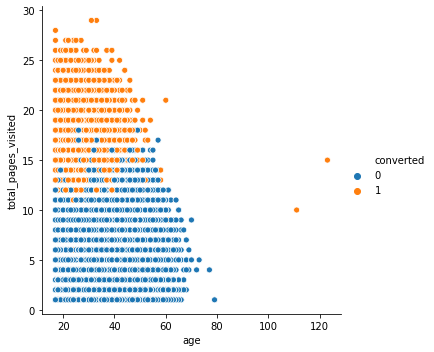

In [14]:
sns.relplot(
     x='age',
     y='total_pages_visited',
     data = CRC,
     hue=CRC.converted)

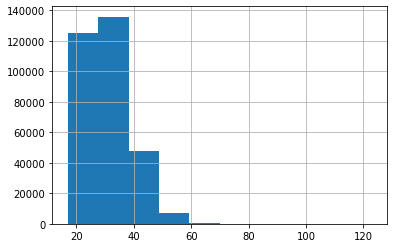

In [15]:
CRC.age.hist()

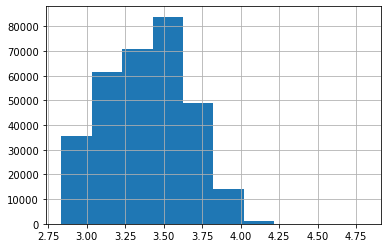

In [16]:
CRC.age.apply(np.log).hist()

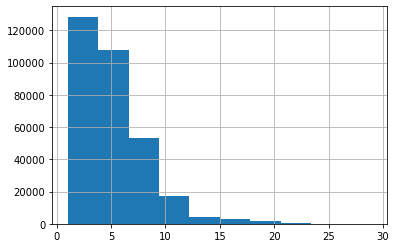

In [17]:
CRC.total_pages_visited.hist()

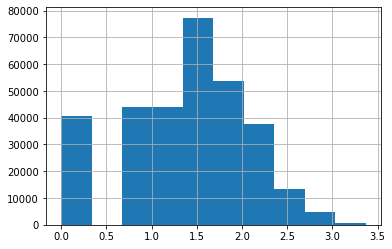

In [18]:
CRC.total_pages_visited.apply(np.log).hist()

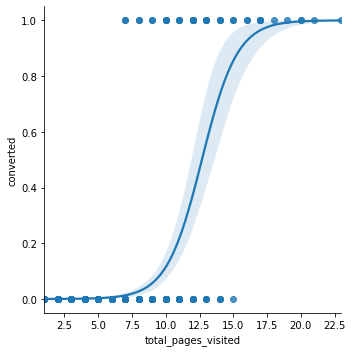

In [19]:
sns.lmplot(x="total_pages_visited", y="converted", data=CRC_sample, logistic = True)

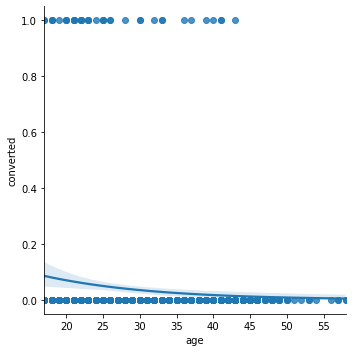

In [20]:
sns.lmplot(x="age", y="converted", data=CRC_sample, logistic = True)

# Logistic Regression <a class="anchor" id="3"></a>

## Dataset with all <a class="anchor" id="1a"></a>

In [13]:
CRC.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [14]:
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable = "converted"

X = CRC.loc[:,features_list]
Y = CRC.loc[:,target_variable]

In [15]:
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
  if ('float' in str(t)) or ('int' in str(t)) :
    numeric_features.append(i)
    numeric_indices.append(idx)
  else :
    categorical_features.append(i)
    categorical_indices.append(idx)

  idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['age', 'new_user', 'total_pages_visited']  at positions  [1, 2, 4]
Found categorical features  ['country', 'source']  at positions  [0, 3]


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, 
                                                    random_state=0, stratify=Y)

In [17]:
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import  OneHotEncoder
from sklearn.compose import ColumnTransformer

# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first')

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)

X_test = featureencoder.transform(X_test)

In [19]:
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression()
regressor.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
from sklearn.metrics import accuracy_score
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

Accuracy on training set :  0.9861130778743852
Accuracy on test set :  0.9863051770072643


## Dataset without outlier and normalize <a class="anchor" id="1b"></a>

In [21]:
features_list = [ 'country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable = "converted"

X1 = CRC1.loc[:,features_list]
Y1 = CRC1.loc[:,target_variable]

X1.shape

(316198, 5)

In [22]:
idx = 0
numeric_features1 = []
numeric_indices1 = []
categorical_features1 = []
categorical_indices1 = []
for i,t in X1.dtypes.iteritems():
  if ('float' in str(t)) or ('int' in str(t)) :
    numeric_features1.append(i)
    numeric_indices1.append(idx)
  else :
    categorical_features1.append(i)
    categorical_indices1.append(idx)

  idx = idx + 1

print('Found numeric features ', numeric_features1,' at positions ', numeric_indices1)
print('Found categorical features ', categorical_features1,' at positions ', categorical_indices1)

Found numeric features  ['age', 'new_user', 'total_pages_visited']  at positions  [1, 2, 4]
Found categorical features  ['country', 'source']  at positions  [0, 3]


In [23]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size=0.33, 
                                                    random_state=0, stratify=Y1)

In [24]:
X_train1 = X_train1.values
X_test1 = X_test1.values
Y_train1 = Y_train1.tolist()
Y_test1 = Y_test1.tolist()

In [25]:
# Normalization
numeric_transformer1 = StandardScaler()

# OHE / dummyfication
categorical_transformer1 = OneHotEncoder(drop='first')

featureencoder1 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer1, categorical_indices1),    
        ('num', numeric_transformer1, numeric_indices1)
        ]
    )

X_train1 = featureencoder1.fit_transform(X_train1)

X_test1 = featureencoder1.transform(X_test1)

In [26]:
regressor1 = LogisticRegression()
regressor1.fit(X_train1, Y_train1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
from sklearn.metrics import accuracy_score
Y_train_pred1 = regressor1.predict(X_train1)
Y_test_pred1 = regressor1.predict(X_test1)

print("Accuracy on training set : ", accuracy_score(Y_train1, Y_train_pred1))
print("Accuracy on test set : ", accuracy_score(Y_test1, Y_test_pred1))

Accuracy on training set :  0.9859666182051621
Accuracy on test set :  0.9862093419968183


In [28]:
regressor1.coef_

array([[ 3.40143524,  3.28591852,  2.92982466, -0.13284379,  0.01339244,
        -0.5449424 , -0.76145294,  5.68801533]])

In [29]:
coefs1 = pd.DataFrame(index= [ 'China','UK', 'Germany', 'age', 'new_user', 'Direct','Seo', 'total_pages_visited'], data = regressor1.coef_.transpose(), columns=["coefficients"])
coefs1

,coefficients
China,3.401435
UK,3.285919
Germany,2.929825
age,-0.132844
new_user,0.013392
Direct,-0.544942
Seo,-0.761453
total_pages_visited,5.688015


In [30]:
#'China','UK', 'Germany'

### Accuracy

Thus, our Logistic Regression model for conversion rate has an accuracy of ~98%. It means that for each pnegative conversion rate it classified, 98% were classified as genuine.

It does not mean that our model performance is excellent. Our Logistic Regression classifier predicted all conversion as genuine. Then we have a accuracy of 98% because it correctly classified 98% conversion as genuine.

Thus, this algorithm is 98% accurate. But it was horrible at classifying positive conversion. So, we should have other ways to measure the model performance. One such measure is confusion matrix described below.

## Confusion matrix <a class="anchor" id="1c"></a>

A confusion matrix is a tool for summarizing the performance of a classification algorithm. A confusion matrix will give us a clear picture of classification model performance and the types of errors produced by the model. It gives us a summary of correct and incorrect predictions broken down by each category. The summary is represented in a tabular form.

Four types of outcomes are possible while evaluating a classification model performance. These four outcomes are described below:-

**True Positives (TP)** – True Positives occur when we predict an observation belongs to a certain class and the observation actually belongs to that class.

**True Negatives (TN)** – True Negatives occur when we predict an observation does not belong to a certain class and the observation actually does not belong to that class.

**False Positives (FP)** – False Positives occur when we predict an observation belongs to a certain class but the observation actually does not belong to that class. This type of error is called **Type I error**.

**False Negatives (FN)** – False Negatives occur when we predict an observation does not belong to a certain class but the observation actually belongs to that class. This is a very serious error and it is called **Type II error**.

These four outcomes are summarized in a confusion matrix given below.

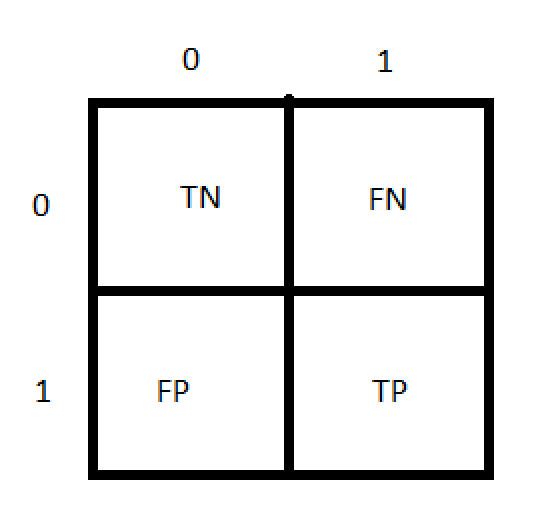

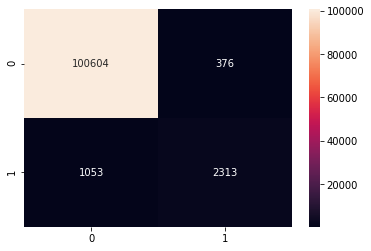

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True, fmt="d")

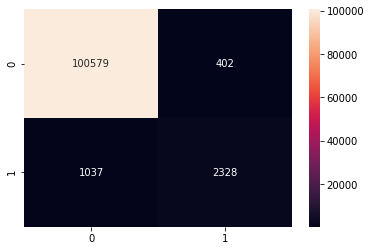

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test1, Y_test_pred1)
sns.heatmap(cm, annot=True, fmt="d")

### Interpretation of confusion matrix

We can conclude that the accuracy of ~98% is misleading because we have imbalanced classes. We need more subtle way to evaluate the performance of the model.

There is another metric called Classification Report which helps to evaluate model performance.



## Classification report <a class="anchor" id="1d"></a>

Classification report is another way to evaluate the classification model performance. It displays the precision, recall, f1 and support scores for the model. I have described these terms in later sections.

We can plot a classification report as follows:-

In [33]:
# import the metric
from sklearn.metrics import classification_report


# print classification report
print("Classification Report:\n\n", classification_report(Y_test, Y_test_pred))

Classification Report:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99    100980
           1       0.86      0.69      0.76      3366

    accuracy                           0.99    104346
   macro avg       0.92      0.84      0.88    104346
weighted avg       0.99      0.99      0.99    104346



In [34]:
# import the metric
from sklearn.metrics import classification_report


# print classification report
print("Classification Report:\n\n", classification_report(Y_test1, Y_test_pred1))

Classification Report:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99    100981
           1       0.85      0.69      0.76      3365

    accuracy                           0.99    104346
   macro avg       0.92      0.84      0.88    104346
weighted avg       0.99      0.99      0.99    104346



### Precision
Precision can be defined as the percentage of correctly predicted positive outcomes out of all the predicted positive outcomes. It can be given as the ratio of true positives (TP) to the sum of true and false positives (TP + FP).

Mathematically, precision can be defined as the ratio of TP to (TP + FP).

So, precision is more concerned with the positive class than the negative class.

### Recall
Recall can be defined as the percentage of correctly predicted positive outcomes out of all the actual positive outcomes. It can be given as the ratio of true positives (TP) to the sum of true positives and false negatives (TP + FN). Recall is also called Sensitivity.

Mathematically, recall can be given as the ratio of TP to (TP + FN).

### f1-score
f1-score is the weighted harmonic mean of precision and recall. The best possible f1-score would be 1.0 and the worst would be 0.0. f1-score is the harmonic mean of precision and recall. So, f1-score is always lower than accuracy measures as they embed precision and recall into their computation. The weighted average of f1-score should be used to compare classifier models, not global accuracy.

### Support
Support is the actual number of occurrences of the class in our dataset. It classifies 100981 conversion as genuine and 3365 conversion as misscalculate.

## Precision - Recall Curve

**Difference between ROC AUC and PR AUC**

Precision-Recall does not account for True Negatives (TN) unlike ROC AUC (TN is not a component of either Precision or Recall).
In the cases of class imbalance problem, we have many more negatives than positives. The Precision-Recall curve much better illustrates the difference between algorithms in the class imbalance problem cases where there are lot more negative examples than the positive examples. In these cases of class imbalances, we should use Precision-Recall Curve (PR AUC), otherwise we should use ROC AUC.
So, we can conclude that we should use PR AUC for cases where the class imbalance problem occurs. Otherwise, we should use ROC AUC.

In [35]:
# compute and print average precision score

from sklearn.metrics import average_precision_score

average_precision = average_precision_score(Y_test, Y_test_pred)

print('Average precision-recall score : {0:0.2f}'.format(average_precision))

Average precision-recall score : 0.60


Precision-Recall Curve gives us the correct accuracy in this imbalanced dataset case. We can see that we have a very poor accuracy for the model.

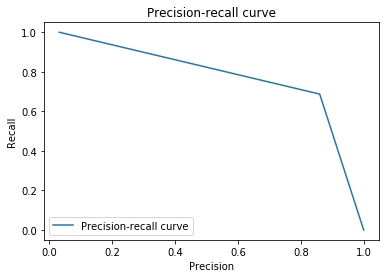

In [36]:
from sklearn.metrics import precision_recall_curve 

precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_pred)

# create plot
plt.plot(precision, recall, label='Precision-recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-recall curve')
plt.legend(loc="lower left")

#  Random over-sampling the minority class <a class="anchor" id="4"></a>

Over-sampling is the process of randomly duplicating observations from the minority class in order to achieve a balanced dataset. So, it replicates the observations from minority class to balance the data. It is also known as upsampling. It may result in overfitting due to duplication of data points.

The most common way of over-sampling is to resample with replacement. I will proceed as follows:-

First, I will import the resampling module from Scikit-Learn.

In [37]:
# import resample module 

from sklearn.utils import resample

In [38]:
# separate the minority and majority classes
CRC_majority = CRC1[CRC1['converted']==0]
CRC_minority = CRC1[CRC1['converted']==1]

In [39]:
# oversample minority class
CRC_minority_oversampled = resample(CRC_minority, replace=True, n_samples=306000, random_state=0)

In [40]:
# combine majority class with oversampled minority class

CRC_oversampled = pd.concat([CRC_majority, CRC_minority_oversampled])

In [41]:
# display new class value counts

CRC_oversampled['converted'].value_counts()

1    306000
0    306000
Name: converted, dtype: int64

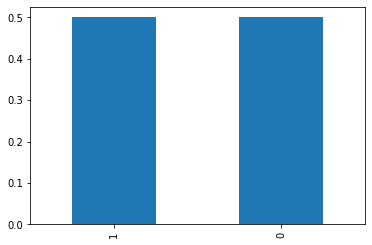

In [42]:
# view the distribution of percentages within the Class column
(CRC_oversampled['converted'].value_counts()/np.float(len(CRC_oversampled))).plot.bar()

In [43]:
# declare feature vector and target variable
features_list2 = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable2 = "converted"

X2 = CRC_oversampled.loc[:,features_list2]
Y2 = CRC_oversampled.loc[:,target_variable2]

idx = 0
numeric_features2 = []
numeric_indices2 = []
categorical_features2 = []
categorical_indices2 = []
for i,t in X2.dtypes.iteritems():
  if ('float' in str(t)) or ('int' in str(t)) :
    numeric_features2.append(i)
    numeric_indices2.append(idx)
  else :
    categorical_features2.append(i)
    categorical_indices2.append(idx)

  idx = idx + 1

print('Found numeric features ', numeric_features2,' at positions ', numeric_indices2)
print('Found categorical features ', categorical_features2,' at positions ', categorical_indices2)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.33, 
                                                    random_state=0, stratify=Y2)

X_train2 = X_train2.values
X_test2 = X_test2.values
Y_train2 = Y_train2.tolist()
Y_test2 = Y_test2.tolist()

# Normalization
numeric_transformer2 = StandardScaler()

# OHE / dummyfication
categorical_transformer2 = OneHotEncoder(drop='first')

featureencoder2 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer2, categorical_indices2),    
        ('num', numeric_transformer2, numeric_indices2)
        ]
    )

X_train2 = featureencoder2.fit_transform(X_train2)

X_test2 = featureencoder2.transform(X_test2)

# instantiate the Logistic Regression classifier
logreg2 = LogisticRegression()

# fit the classifier to the imbalanced data
clf2 = logreg2.fit(X_train2, Y_train2)


Y_train_pred2 = clf2.predict(X_train2)
Y_test_pred2 = clf2.predict(X_test2)

print("Accuracy on training set : ", accuracy_score(Y_train2, Y_train_pred2))
print("Accuracy on test set : ", accuracy_score(Y_test2, Y_test_pred2))

# print classification report
print("Classification Report:\n\n", classification_report(Y_test2, Y_test_pred2))

Found numeric features  ['age', 'new_user', 'total_pages_visited']  at positions  [1, 2, 4]
Found categorical features  ['country', 'source']  at positions  [0, 3]
Accuracy on training set :  0.9401570578480148
Accuracy on test set :  0.9398148148148148
Classification Report:

               precision    recall  f1-score   support

           0       0.95      0.93      0.94    100980
           1       0.93      0.95      0.94    100980

    accuracy                           0.94    201960
   macro avg       0.94      0.94      0.94    201960
weighted avg       0.94      0.94      0.94    201960



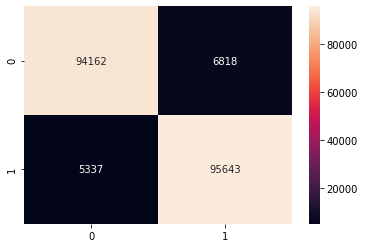

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test2, Y_test_pred2)
sns.heatmap(cm, annot=True, fmt="d")

**Advantages**

An advantage of this method is that it leads to no information loss.

This method outperform under sampling.

**Disadvantages**

This method increases the likelihood of overfitting as it replicates the minority class labels.

# Random under-sampling the majority class <a class="anchor" id="5"></a>

The under-sampling methods work with the majority class. In these methods, we randomly eliminate instances of the majority class. It reduces the number of observations from majority class to make the dataset balanced. This method is applicable when the dataset is huge and reducing the number of training samples make the dataset balanced.

The most common technique for under-sampling is resampling without replacement.

I will proceed exactly as in the case of random over-sampling.

In [45]:
# separate the minority and majority classes
CRC_majority = CRC1[CRC1['converted']==0]
CRC_minority = CRC1[CRC1['converted']==1]

In [46]:
# undersample majority class
CRC_majority_undersampled = resample(CRC_majority, replace=True, n_samples=10200, random_state=0)

In [47]:
# combine majority class with oversampled minority class
CRC_undersampled = pd.concat([CRC_minority, CRC_majority_undersampled])

# display new class value counts
CRC_undersampled['converted'].value_counts()

0    10200
1    10198
Name: converted, dtype: int64

In [48]:
# declare feature vector and target variable
features_list3 = ['country', 'age','new_user', 'source',  'total_pages_visited']
target_variable3 = "converted"

X3 = CRC_undersampled.loc[:,features_list3]
Y3 = CRC_undersampled.loc[:,target_variable3]

idx = 0
numeric_features3 = []
numeric_indices3 = []
categorical_features3 = []
categorical_indices3 = []
for i,t in X3.dtypes.iteritems():
  if ('float' in str(t)) or ('int' in str(t)) :
    numeric_features3.append(i)
    numeric_indices3.append(idx)
  else :
    categorical_features3.append(i)
    categorical_indices3.append(idx)

  idx = idx + 1

print('Found numeric features ', numeric_features3,' at positions ', numeric_indices3)
print('Found categorical features ', categorical_features3,' at positions ', categorical_indices3)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, Y3, test_size=0.33, 
                                                    random_state=0, stratify=Y3)

X_train3 = X_train3.values
X_test3 = X_test3.values
Y_train3 = Y_train3.tolist()
Y_test3 = Y_test3.tolist()

# Normalization
numeric_transformer3 = StandardScaler()

# OHE / dummyfication
categorical_transformer3 = OneHotEncoder(drop='first')

featureencoder3 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer3, categorical_indices3),    
        ('num', numeric_transformer3, numeric_indices3)
        ]
    )

X_train3 = featureencoder3.fit_transform(X_train3)

X_test3 = featureencoder3.transform(X_test3)

# instantiate the Logistic Regression classifier
logreg3 = LogisticRegression()

# fit the classifier to the imbalanced data
clf3 = logreg3.fit(X_train3, Y_train3)


Y_train_pred3 = clf3.predict(X_train3)
Y_test_pred3 = clf3.predict(X_test3)

print("Accuracy on training set : ", accuracy_score(Y_train3, Y_train_pred3))
print("Accuracy on test set : ", accuracy_score(Y_test3, Y_test_pred3))

# print classification report
print("Classification Report:\n\n", classification_report(Y_test3, Y_test_pred3))

Found numeric features  ['age', 'new_user', 'total_pages_visited']  at positions  [1, 2, 4]
Found categorical features  ['country', 'source']  at positions  [0, 3]
Accuracy on training set :  0.9408019903409922
Accuracy on test set :  0.9389483065953654
Classification Report:

               precision    recall  f1-score   support

           0       0.95      0.93      0.94      3366
           1       0.93      0.95      0.94      3366

    accuracy                           0.94      6732
   macro avg       0.94      0.94      0.94      6732
weighted avg       0.94      0.94      0.94      6732



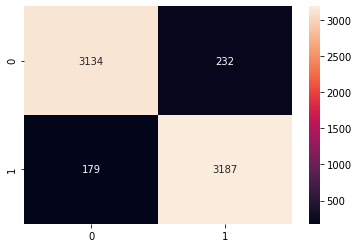

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test3, Y_test_pred3)
sns.heatmap(cm, annot=True, fmt="d")

**Advantages**

If the dataset is huge, we might face run time and storage problems. Undersampling can help to handle these problems successfully by improving run time and storage problems by reducing the number of training data samples.

**Disadvantages**

This method can discard potentially useful information which could be important for building the classifiers.

The sample chosen by random under sampling may be a biased one. It may not be an accurate representation of the population. So, it results in inaccurate results with the actual dataset.

# Apply Tree-Based Algorithms <a class="anchor" id="6"></a>

## Random Forest classifier <a class="anchor" id="2a"></a>

In [50]:
# declare input features (X) and target variable (y)
features_list4 = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable4 = "converted"

X4 = CRC.loc[:,features_list4]
Y4 = CRC.loc[:,target_variable4]

idx = 0
numeric_features4 = []
numeric_indices4 = []
categorical_features4 = []
categorical_indices4 = []
for i,t in X4.dtypes.iteritems():
  if ('float' in str(t)) or ('int' in str(t)) :
    numeric_features4.append(i)
    numeric_indices4.append(idx)
  else :
    categorical_features4.append(i)
    categorical_indices4.append(idx)

  idx = idx + 1

print('Found numeric features ', numeric_features4,' at positions ', numeric_indices4)
print('Found categorical features ', categorical_features4,' at positions ', categorical_indices4)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, Y4, test_size=0.33, 
                                                    random_state=0, stratify=Y4)

X_train4 = X_train4.values
X_test4 = X_test4.values
Y_train4 = Y_train4.tolist()
Y_test4 = Y_test4.tolist()

# Normalization
numeric_transformer4 = StandardScaler()

# OHE / dummyfication
categorical_transformer4 = OneHotEncoder(drop='first')

featureencoder4 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer4, categorical_indices4),    
        ('num', numeric_transformer4, numeric_indices4)
        ]
    )

X_train4 = featureencoder3.fit_transform(X_train4)

X_test4 = featureencoder3.transform(X_test4)

Found numeric features  ['age', 'new_user', 'total_pages_visited']  at positions  [1, 2, 4]
Found categorical features  ['country', 'source']  at positions  [0, 3]


In [51]:
# import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

In [52]:
# instantiate the Random Forest classifier
RandomF4 = RandomForestClassifier(criterion="gini")

# fit the classifier to the imbalanced data
clf4 = RandomF4.fit(X_train4, Y_train4)


Y_train_pred4 = clf4.predict(X_train4)
Y_test_pred4 = clf4.predict(X_test4)

print("Accuracy on training set : ", accuracy_score(Y_train4, Y_train_pred4))
print("Accuracy on test set : ", accuracy_score(Y_test4, Y_test_pred4))

# print classification report
print("Classification Report:\n\n", classification_report(Y_test4, Y_test_pred4))

Accuracy on training set :  0.9884967949625686
Accuracy on test set :  0.9842255572805857
Classification Report:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99    100980
           1       0.81      0.66      0.73      3366

    accuracy                           0.98    104346
   macro avg       0.90      0.83      0.86    104346
weighted avg       0.98      0.98      0.98    104346



In [53]:
# instantiate the Random Forest classifier
RandomF4_1 = RandomForestClassifier(criterion="entropy")

# fit the classifier to the imbalanced data
clf4_1 = RandomF4_1.fit(X_train4, Y_train4)


Y_train_pred4_1 = clf4_1.predict(X_train4)
Y_test_pred4_1 = clf4_1.predict(X_test4)

print("Accuracy on training set : ", accuracy_score(Y_train4, Y_train_pred4_1))
print("Accuracy on test set : ", accuracy_score(Y_test4, Y_test_pred4_1))

# print classification report
print("Classification Report:\n\n", classification_report(Y_test4, Y_test_pred4_1))

Accuracy on training set :  0.9884967949625686
Accuracy on test set :  0.9844747283077454
Classification Report:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99    100980
           1       0.82      0.67      0.74      3366

    accuracy                           0.98    104346
   macro avg       0.90      0.83      0.86    104346
weighted avg       0.98      0.98      0.98    104346



## Comparaison method between gini and entropy <a class="anchor" id="2b"></a>

In [54]:
count = 0
for i in range(0, len(Y_test_pred4)):
  
  if Y_test_pred4[i] != Y_test_pred4_1[i]:
    count+= 1
    

print("On the test set, there are {}  differently classified items".format(count))
print("Either {}%  difference".format(np.round(count/len(Y_test_pred4), 3)*100))

On the test set, there are 142  differently classified items
Either 0.1%  difference


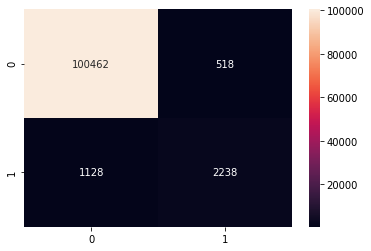

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test4, Y_test_pred4)
sns.heatmap(cm, annot=True, fmt="d")

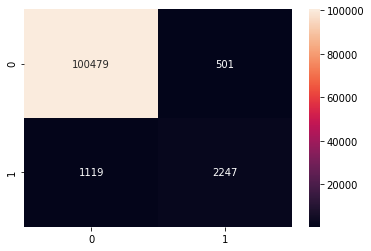

In [56]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test4, Y_test_pred4_1)
sns.heatmap(cm, annot=True, fmt="d")

## GridsearchCV <a class="anchor" id="2c"></a>

In [192]:
#param = {"n_estimators": np.arange(10,50),
#        "max_depth": np.arange(1,10),
#        "min_samples_split":np.arange(2,10)}

In [197]:
#from sklearn.model_selection import GridSearchCV
#rf = RandomForestClassifier()
#grid = GridSearchCV( estimator = rf, param_grid=param)
#grid.fit(X_train4,Y_train4)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=No...
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8

In [198]:
#grid.best_params_
#{'max_depth': 8, 'min_samples_split': 9, 'n_estimators': 48}

{'max_depth': 8, 'min_samples_split': 9, 'n_estimators': 48}

In [208]:
#grid.best_estimator_.score(X_train4, Y_train4)
#0.9863774108584213

0.9863774108584213

In [207]:
#grid.best_estimator_.score(X_test4, Y_test4)
#0.9859601709696586

0.9859601709696586

In [204]:
# instantiate the Random Forest classifier
RandomF4_2 = RandomForestClassifier(n_estimators= 8,max_depth= 9,min_samples_split=48)

# fit the classifier to the imbalanced data
clf4_2 = RandomF4_2.fit(X_train4, Y_train4)


Y_train_pred4_2 = clf4_2.predict(X_train4)
Y_test_pred4_2 = clf4_2.predict(X_test4)

print("Accuracy on training set : ", accuracy_score(Y_train4, Y_train_pred4_2))
print("Accuracy on test set : ", accuracy_score(Y_test4, Y_test_pred4_2))

# print classification report
print("Classification Report:\n\n", classification_report(Y_test4, Y_test_pred4_2))

Accuracy on training set :  0.9864576548000038
Accuracy on test set :  0.9859697544707032
Classification Report:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99    100980
           1       0.86      0.68      0.76      3366

    accuracy                           0.99    104346
   macro avg       0.92      0.84      0.87    104346
weighted avg       0.99      0.99      0.99    104346



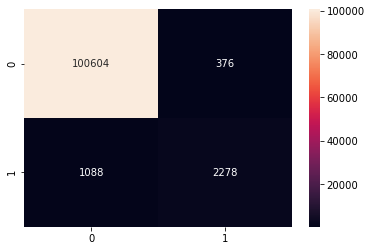

In [205]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test4, Y_test_pred4_2)
sns.heatmap(cm, annot=True, fmt="d")

## Under-sampling the majority class with random forest <a class="anchor" id="2d"></a>

In [213]:
#param = {"n_estimators": np.arange(10,50),
#        "max_depth": np.arange(1,10),
#        "min_samples_split":np.arange(2,10)}

In [214]:
#from sklearn.model_selection import GridSearchCV
#rf = RandomForestClassifier()
#grid = GridSearchCV( estimator = rf, param_grid=param)
#grid.fit(X_train3,Y_train3)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=No...
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8

In [215]:
#grid.best_params_
#{'max_depth': 8, 'min_samples_split': 3, 'n_estimators': 23}

{'max_depth': 8, 'min_samples_split': 3, 'n_estimators': 23}

In [315]:
#grid.best_estimator_.score(X_train3, Y_train3)
#0.9145324162154251

0.9145324162154251

In [316]:
#grid.best_estimator_.score(X_test3, Y_test3)
#0.9197860962566845

0.9197860962566845

In [317]:
# instantiate the Random Forest classifier
RandomF3_1 = RandomForestClassifier(n_estimators= 23,max_depth= 8,min_samples_split=3)

# fit the classifier to the imbalanced data
clf3_1 = RandomF3_1.fit(X_train3, Y_train3)


Y_train_pred3_1 = clf3_1.predict(X_train3)
Y_test_pred3_1 = clf3_1.predict(X_test3)

print("Accuracy on training set : ", accuracy_score(Y_train3, Y_train_pred3_1))
print("Accuracy on test set : ", accuracy_score(Y_test3, Y_test_pred3_1))

# print classification report
print("Classification Report:\n\n", classification_report(Y_test3, Y_test_pred3_1))

Accuracy on training set :  0.945265622713303
Accuracy on test set :  0.9340463458110517
Classification Report:

               precision    recall  f1-score   support

           0       0.93      0.94      0.93      3366
           1       0.94      0.93      0.93      3366

    accuracy                           0.93      6732
   macro avg       0.93      0.93      0.93      6732
weighted avg       0.93      0.93      0.93      6732



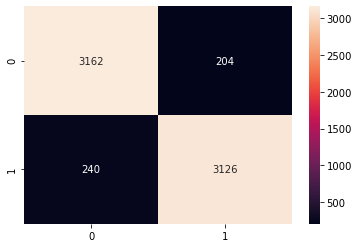

In [318]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test3, Y_test_pred3_1)
sns.heatmap(cm, annot=True, fmt="d")

# SMOTETomek <a class="anchor" id="7"></a>

Resampling technique named SMOTETomek, which combines undersampling and oversampling. SMOTETomek is a good way to avoid the disadvantages of the SMOTE and the Tomek Link technique. The SMOTETomek technique is applied using the library from imbalanced_learn, and included an SMOTE function for oversampling as well as a Tomek Link function for undersampling. The algorithm flow of the SMOTETomek method is to combine SMOTE and Tomek Link to form a pipeline. The standard flow is as follows:

Step 1: For a dataset D with an unbalanced data distribution, it uses the SMOTE method to obtain an extended dataset D’ by generating many new minority samples.

Step2: Tomek Link pairs in dataset D’ are removed using the Tomek Link method.


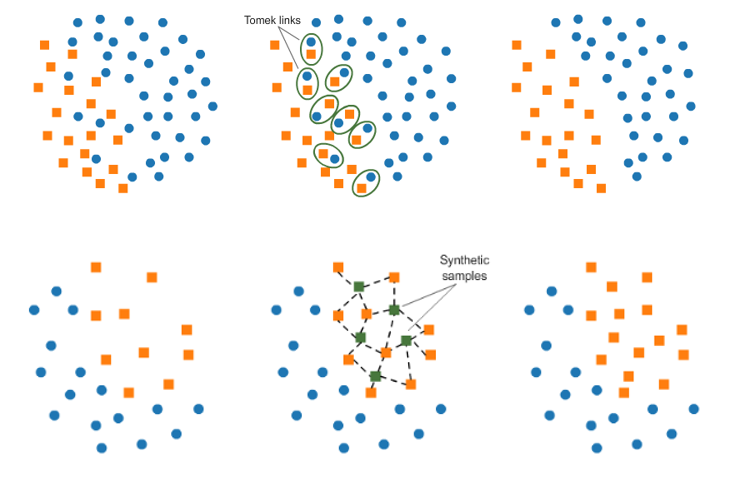

In [57]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

In [58]:
from imblearn.combine import SMOTETomek

In [59]:
print('Original dataset shape {}'.format(Counter(Y_train1)))

Original dataset shape Counter({0: 205019, 1: 6833})


In [60]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)

# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X_train1)


# Apply the random under-sampling
tl = SMOTETomek(sampling_strategy='not majority')
X_resampled, Y_resampled = tl.fit_sample(X_train1, Y_train1)
X_res_vis = pca.transform(X_resampled)

print('Resampled dataset shape %s' % Counter(Y_resampled))


Resampled dataset shape Counter({0: 204868, 1: 204868})


In [61]:
X.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')

In [62]:
regressor = LogisticRegression()
reg = regressor.fit(X_resampled, Y_resampled)

Y_train_pred11 = reg.predict(X_resampled)
Y_test_pred11 = reg.predict(X_test1)

print("Accuracy on training set : ", accuracy_score(Y_resampled, Y_train_pred11))
print("Accuracy on test set : ", accuracy_score(Y_test1, Y_test_pred11))

# print classification report
print("Classification Report:\n\n", classification_report(Y_test1, Y_test_pred11))

Accuracy on training set :  0.9458431770701135
Accuracy on test set :  0.9364997220784697
Classification Report:

               precision    recall  f1-score   support

           0       1.00      0.94      0.97    100981
           1       0.33      0.94      0.49      3365

    accuracy                           0.94    104346
   macro avg       0.66      0.94      0.73    104346
weighted avg       0.98      0.94      0.95    104346



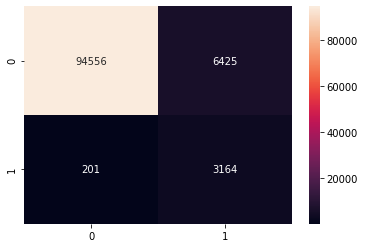

In [63]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test1, Y_test_pred11)
sns.heatmap(cm, annot=True, fmt="d")

The disadvantage of the oversampling technique is that there are too many repeated samples, which may lead to overfitting of the classifier.